# Data Preprocessing (LendingClub)

This notebook builds a reproducible preprocessing pipeline for default-risk modeling using `loan.csv` and the LendingClub data dictionary.

Outputs:
- `X_train`, `X_val`, `X_test`
- `y_train`, `y_val`, `y_test`
- feature names and split summary


## 1) Setup
Set paths and import dependencies.


In [18]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option("display.max_columns", 200)

RAW_DATA_PATH = Path("/Users/peisun/Downloads/archive/loan.csv")
DICT_PATH = Path("/Users/peisun/Downloads/archive/LCDataDictionary.xlsx")
OUT_DIR = Path("milestone/processed_from_notebook")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# For quick debugging, set SAMPLE_ROWS to an integer (e.g., 200000).
SAMPLE_ROWS = None

if not RAW_DATA_PATH.exists():
    raise FileNotFoundError(f"Missing data file: {RAW_DATA_PATH}")

print("Raw data:", RAW_DATA_PATH)
print("Data dictionary:", DICT_PATH, "(exists:", DICT_PATH.exists(), ")")
print("Output dir:", OUT_DIR.resolve())

Raw data: /Users/peisun/Downloads/archive/loan.csv
Data dictionary: /Users/peisun/Downloads/archive/LCDataDictionary.xlsx (exists: True )
Output dir: /Users/peisun/berkeley_datasci_207_proj/milestone/milestone/processed_from_notebook


## 2) Load Data

In [19]:
df = pd.read_csv(RAW_DATA_PATH, low_memory=False, nrows=SAMPLE_ROWS)
print("Shape:", df.shape)
print("Columns:", len(df.columns))
df.head(2)

Shape: (2260668, 145)
Columns: 145


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 3) Target Definition and Outcome Filtering
We keep only loans whose outcome is already known — either `Fully Paid` or `Charged Off`. These become our labels. `loan_status` is used solely to build the target (`default_label`) and is dropped from features when we train models, so it never leaks into X.

In [20]:
POSITIVE_STATUS = {"Charged Off"}
NEGATIVE_STATUS = {"Fully Paid"}

# Keep only final-outcome loans where repayment result is known.
# loan_status is included here only to build default_label; it gets dropped from X before modeling.
SELECTED_FEATURES = [
    "loan_amnt",
    "loan_status",
    "grade",
    "sub_grade",
    "term",
    "emp_length",
    "annual_inc",
]

# Keep issue_d only for time-based split (not part of modeling features).
SPLIT_COL = "issue_d"

available_features = [c for c in SELECTED_FEATURES if c in df.columns]
missing_features = [c for c in SELECTED_FEATURES if c not in df.columns]

if SPLIT_COL not in df.columns:
    raise ValueError(f"Missing required split column: {SPLIT_COL}")
if "loan_status" not in available_features:
    raise ValueError("loan_status is required to build default_label")

if missing_features:
    print("[WARN] Missing requested features in this dataset:", missing_features)
    print("[WARN] Pipeline will continue with available requested features only.")

base_cols = available_features + [SPLIT_COL]
base = df[base_cols].copy()
base = base[base["loan_status"].isin(POSITIVE_STATUS | NEGATIVE_STATUS)].copy()
base["default_label"] = base["loan_status"].isin(POSITIVE_STATUS).astype(int)

print("Rows after target filtering:", len(base))
print(base["loan_status"].value_counts(dropna=False))
print("Default rate:", round(base["default_label"].mean(), 4))
print("Included statuses:", POSITIVE_STATUS | NEGATIVE_STATUS)
print("Requested features:", SELECTED_FEATURES)
print("Available features used:", available_features)


Rows after target filtering: 1303607
loan_status
Fully Paid     1041952
Charged Off     261655
Name: count, dtype: int64
Default rate: 0.2007
Included statuses: {'Charged Off', 'Fully Paid'}
Requested features: ['loan_amnt', 'loan_status', 'grade', 'sub_grade', 'term', 'emp_length', 'annual_inc']
Available features used: ['loan_amnt', 'loan_status', 'grade', 'sub_grade', 'term', 'emp_length', 'annual_inc']


## 4) Basic Cleaning

In [21]:
def parse_issue_date(col: pd.Series) -> pd.Series:
    return pd.to_datetime(col, format="%b-%Y", errors="coerce")

def clean_percent(col: pd.Series) -> pd.Series:
    if col.dtype == object:
        return pd.to_numeric(col.astype(str).str.replace("%", "", regex=False), errors="coerce")
    return pd.to_numeric(col, errors="coerce")

def clean_term(col: pd.Series) -> pd.Series:
    return pd.to_numeric(col.astype(str).str.extract(r"(\d+)")[0], errors="coerce")

def clean_emp_length(col: pd.Series) -> pd.Series:
    s = col.astype(str).str.strip().str.lower()
    s = s.replace({"nan": np.nan, "< 1 year": "0", "10+ years": "10"})
    s = s.str.extract(r"(\d+)")[0]
    return pd.to_numeric(s, errors="coerce")

work = base.copy()
work["issue_d"] = parse_issue_date(work["issue_d"])

if "term" in work.columns:
    work["term"] = clean_term(work["term"])
if "emp_length" in work.columns:
    work["emp_length"] = clean_emp_length(work["emp_length"])

for col in ["total_pymnt", "loan_amnt", "annual_inc"]:
    if col in work.columns:
        work[col] = pd.to_numeric(work[col], errors="coerce")
if "int_rate" in work.columns:
    work["int_rate"] = clean_percent(work["int_rate"])

# grade/sub_grade: ordinal encode for modeling (A=1..G=7, A1=1..G5=35)
grade_order = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
if "grade" in work.columns:
    work["grade"] = work["grade"].map(grade_order)
if "sub_grade" in work.columns:
    work["sub_grade"] = (work["sub_grade"].str[0].map(grade_order).astype(float) - 1) * 5 + pd.to_numeric(work["sub_grade"].str[1], errors="coerce")

print("Shape after feature selection and cleaning:", work.shape)
print(work.head(2))


Shape after feature selection and cleaning: (1303607, 9)
     loan_amnt loan_status  grade  sub_grade  term  emp_length  annual_inc  \
100      30000  Fully Paid      4       20.0    36         5.0    100000.0   
152      40000  Fully Paid      3       14.0    60         0.0     45000.0   

       issue_d  default_label  
100 2018-12-01              0  
152 2018-12-01              0  


## 5) EDA for Selected Features
We have 6 business features (loan_amnt, grade, sub_grade, term, emp_length, annual_inc) plus `issue_year` and `issue_month` from `issue_d`, giving 8 columns in the final X. Here we do a quick EDA on the data before the time split:
- Numeric distributions
- Categorical default-rate comparison
- Correlation heatmap (numeric subset)

EDA shape: (1303607, 8)
EDA columns: ['loan_amnt', 'loan_status', 'grade', 'sub_grade', 'term', 'emp_length', 'annual_inc', 'default_label']
Missing ratio (selected features):
emp_length       0.0579
loan_amnt        0.0000
loan_status      0.0000
grade            0.0000
sub_grade        0.0000
term             0.0000
annual_inc       0.0000
default_label    0.0000
dtype: float64


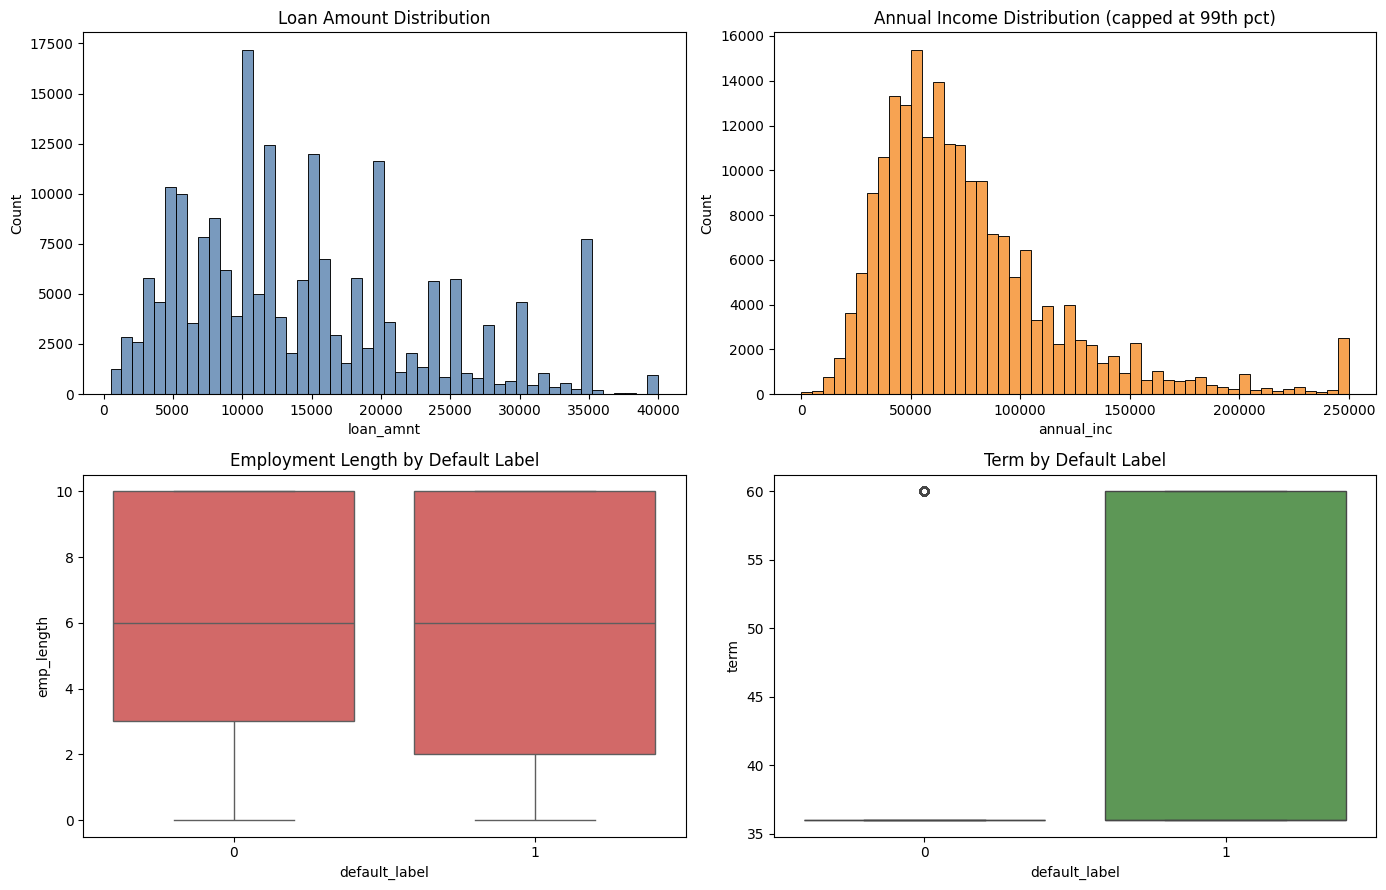


Default rate by grade (top 15 rows):


,grade,default_label
6,7,0.500726
5,6,0.453038
4,5,0.386196
3,4,0.304389
2,3,0.225076
1,2,0.134359
0,1,0.060846



Default rate by sub_grade (top 15 rows):


,sub_grade,default_label
34,35.0,0.536044
32,33.0,0.514752
33,34.0,0.512719
29,30.0,0.493942
31,32.0,0.491663
30,31.0,0.481329
28,29.0,0.479615
26,27.0,0.454764
27,28.0,0.451936
25,26.0,0.423203



Default rate by term (top 15 rows):


,term,default_label
1,60,0.325568
0,36,0.160959



Default rate by emp_length (top 15 rows):


,emp_length,default_label
0,0.0,0.206791
1,1.0,0.206485
3,3.0,0.200893
8,8.0,0.200626
9,9.0,0.200226
2,2.0,0.199262
4,4.0,0.198926
5,5.0,0.196967
7,7.0,0.195752
6,6.0,0.194607


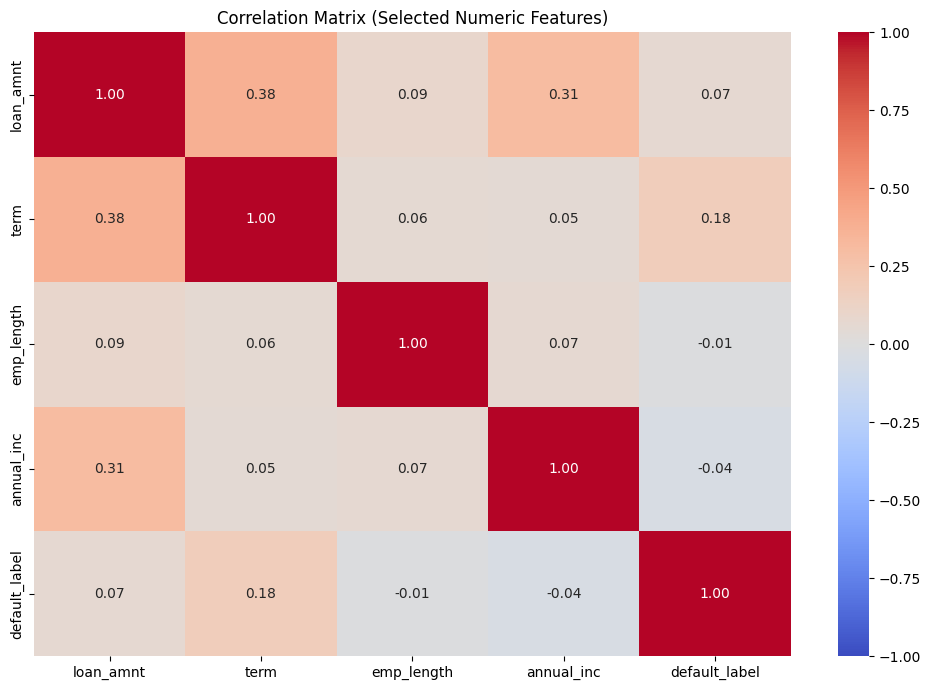

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

requested_eda_cols = [
    "loan_amnt", "loan_status", "grade", "sub_grade", "term",
    "emp_length", "annual_inc", "default_label"
]
eda_cols = [c for c in requested_eda_cols if c in work.columns]
eda = work[eda_cols].copy()

print("EDA shape:", eda.shape)
print("EDA columns:", eda_cols)
print("Missing ratio (selected features):")
print(eda.isna().mean().sort_values(ascending=False).round(4))

# Keep plotting responsive on full dataset.
EDA_SAMPLE = 200000
plot_df = eda if len(eda) <= EDA_SAMPLE else eda.sample(EDA_SAMPLE, random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

if "loan_amnt" in plot_df.columns:
    sns.histplot(plot_df["loan_amnt"], bins=50, kde=False, ax=axes[0, 0], color="#4c78a8")
    axes[0, 0].set_title("Loan Amount Distribution")
else:
    axes[0, 0].set_visible(False)

if "annual_inc" in plot_df.columns:
    annual_plot = plot_df["annual_inc"]
    annual_plot = annual_plot.clip(upper=annual_plot.quantile(0.99))
    sns.histplot(annual_plot, bins=50, kde=False, ax=axes[0, 1], color="#f58518")
    axes[0, 1].set_title("Annual Income Distribution (capped at 99th pct)")
else:
    axes[0, 1].set_visible(False)

# total_pymnt removed to avoid leakage; use emp_length instead for 4th plot
if "emp_length" in plot_df.columns:
    sns.boxplot(data=plot_df, x="default_label", y="emp_length", ax=axes[1, 0], color="#e45756")
    axes[1, 0].set_title("Employment Length by Default Label")
    axes[1, 0].set_xlabel("default_label")
else:
    axes[1, 0].set_visible(False)

if "term" in plot_df.columns:
    sns.boxplot(data=plot_df, x="default_label", y="term", ax=axes[1, 1], color="#54a24b")
    axes[1, 1].set_title("Term by Default Label")
    axes[1, 1].set_xlabel("default_label")
else:
    axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

# Default rate by categorical features.
cat_features = [c for c in ["grade", "sub_grade", "term", "emp_length"] if c in eda.columns]
for col in cat_features:
    tmp = (
        eda[[col, "default_label"]]
        .dropna()
        .groupby(col, as_index=False)["default_label"]
        .mean()
        .sort_values("default_label", ascending=False)
    )
    print(f"\nDefault rate by {col} (top 15 rows):")
    display(tmp.head(15))

# Numeric correlation matrix for selected numeric fields.
num_for_corr_requested = ["loan_amnt", "term", "emp_length", "annual_inc", "default_label"]
num_for_corr = [c for c in num_for_corr_requested if c in eda.columns]

if len(num_for_corr) >= 2:
    corr = eda[num_for_corr].corr(numeric_only=True)
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Matrix (Selected Numeric Features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")


## 6) Time-Based Split
We sort by `issue_d` and split 70/15/15 into train/val/test so the model never sees future data. X excludes `loan_status` and `default_label` — only the features go into the model.


In [23]:
MISSING_THRESHOLD = 0.40
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

# Drop high-missing columns first
missing_ratio = work.isna().mean()
high_missing = missing_ratio[missing_ratio > MISSING_THRESHOLD].index.tolist()
work = work.drop(columns=high_missing, errors="ignore")

work = work[work["issue_d"].notna()].sort_values("issue_d").reset_index(drop=True)

y = work["default_label"].copy()
# avoid data leakage by excluding loan_status (target variable)
X = work.drop(columns=["default_label", "loan_status"]).copy()

n = len(X)
train_end = int(n * TRAIN_RATIO)
val_end = int(n * (TRAIN_RATIO + VAL_RATIO))

X_train = X.iloc[:train_end].copy()
X_val = X.iloc[train_end:val_end].copy()
X_test = X.iloc[val_end:].copy()

y_train = y.iloc[:train_end].copy()
y_val = y.iloc[train_end:val_end].copy()
y_test = y.iloc[val_end:].copy()

for frame in [X_train, X_val, X_test]:
    frame["issue_year"] = frame["issue_d"].dt.year
    frame["issue_month"] = frame["issue_d"].dt.month
    frame.drop(columns=["issue_d"], inplace=True)

summary = pd.DataFrame({
    "split": ["train", "val", "test"],
    "rows": [len(X_train), len(X_val), len(X_test)],
    "default_rate": [y_train.mean(), y_val.mean(), y_test.mean()],
})
summary

,split,rows,default_rate
0,train,912524,0.187441
1,val,195541,0.254116
2,test,195542,0.209270


## 7) ColumnTransformer Preprocessing
- Numeric: median imputation + scaling
- Categorical: most-frequent imputation + one-hot encoding


In [24]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
)

X_train_arr = preprocessor.fit_transform(X_train)
X_val_arr = preprocessor.transform(X_val)
X_test_arr = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

X_train_prep = pd.DataFrame(X_train_arr, columns=feature_names)
X_val_prep = pd.DataFrame(X_val_arr, columns=feature_names)
X_test_prep = pd.DataFrame(X_test_arr, columns=feature_names)

print("Prepared shapes:")
print("X_train:", X_train_prep.shape)
print("X_val:", X_val_prep.shape)
print("X_test:", X_test_prep.shape)

Numeric cols: 8
Categorical cols: 0
Prepared shapes:
X_train: (912524, 8)
X_val: (195541, 8)
X_test: (195542, 8)


## 8) Export Processed Datasets

In [25]:
# Display-only mode: do not write output files.
print("Display-only mode enabled: no files will be written.")

print("\nPrepared dataset shapes:")
print("X_train:", X_train_prep.shape)
print("X_val:", X_val_prep.shape)
print("X_test:", X_test_prep.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

print("\nSplit summary:")
display(summary)

feature_df = pd.DataFrame({"feature": feature_names})
print("\nFeature count:", len(feature_df))
print("Feature sample (first 30):")
display(feature_df.head(30))


Display-only mode enabled: no files will be written.

Prepared dataset shapes:
X_train: (912524, 8)
X_val: (195541, 8)
X_test: (195542, 8)
y_train: (912524,)
y_val: (195541,)
y_test: (195542,)

Split summary:


,split,rows,default_rate
0,train,912524,0.187441
1,val,195541,0.254116
2,test,195542,0.209270



Feature count: 8
Feature sample (first 30):


,feature
0,num__loan_amnt
1,num__grade
2,num__sub_grade
3,num__term
4,num__emp_length
5,num__annual_inc
6,num__issue_year
7,num__issue_month


## 9) Notes
- This pipeline is for default-risk prediction at/near origination, so post-outcome columns are removed.
- Time-based split is required to avoid look-ahead bias.
- For modeling, start with Logistic Regression and class weighting; then compare tree-based models.
